# 전국폐기물 발생 및 처리현황(2014년~2021년까지)
- 발생년도, 시도, 시군구, 폐기물 대분류, 폐기물 중분류, 폐기물 소분류, 전체발생량, 총계_재활용, 총계_소각, 총계_매립, 총계_기타
- 시군구별 페기물 종류별 발생량을 예측하는 모델을 만들어 봅니다

In [1]:
# 데이터 분석 패키지
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝 모델 및 평가 패키지
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve


In [2]:
# 데이터 불러오기
data = pd.read_csv('data/combined_data.csv')
data.head()

,발생년도,시도,시군구,폐기물 대분류,폐기물 중분류,폐기물 소분류,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
0,2014,전국,합계,NaN,NaN,NaN,42355.2,24552.9,11530.6,6271.7,0.0
1,2014,서울,종로구,NaN,NaN,NaN,290.9,170.4,88.1,32.4,0.0
2,2014,서울,중구,NaN,NaN,NaN,410.6,258.6,132.6,19.4,0.0
3,2014,서울,용산구,NaN,NaN,NaN,245.4,158.1,79.1,8.2,0.0
4,2014,서울,성동구,NaN,NaN,NaN,228.6,142.6,65.1,20.9,0.0


In [3]:
# 데이터의 통계 정보 확인
data.describe()

,발생년도,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
count,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000,32403.000000
mean,2019.857421,54.758106,26.890739,18.494886,9.171287,0.199981
std,1.124376,811.147867,457.196534,279.030544,133.651107,3.902260
min,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2020.000000,1.100000,0.000000,0.000000,0.000000,0.000000
75%,2021.000000,11.100000,2.400000,1.100000,0.450000,0.000000
max,2021.000000,47403.800000,27774.800000,13852.600000,6782.800000,295.600000


In [4]:
# 데이터의 결측치 확인
data.isnull().sum()

# 데이터의 타입 확인
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32403 entries, 0 to 32402
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   발생년도     32403 non-null  int64  
 1   시도       32403 non-null  object 
 2   시군구      32403 non-null  object 
 3   폐기물 대분류  31248 non-null  object 
 4   폐기물 중분류  31248 non-null  object 
 5   폐기물 소분류  31248 non-null  object 
 6   전체발생량    32403 non-null  float64
 7   총계_재활용   32403 non-null  float64
 8   총계_소각    32403 non-null  float64
 9   총계_매립    32403 non-null  float64
 10  총계_기타    32403 non-null  float64
dtypes: float64(5), int64(1), object(5)
memory usage: 2.7+ MB


In [5]:
# matplotlib 한글 폰트 오류 문제 해결, 맥,리눅스,윈도우 별로 폰트 설정
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Linux':
    # path = "/usr/share/fonts/NanumFont/NanumGothic.ttf"
    path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('알수없는 시스템. 미적용')



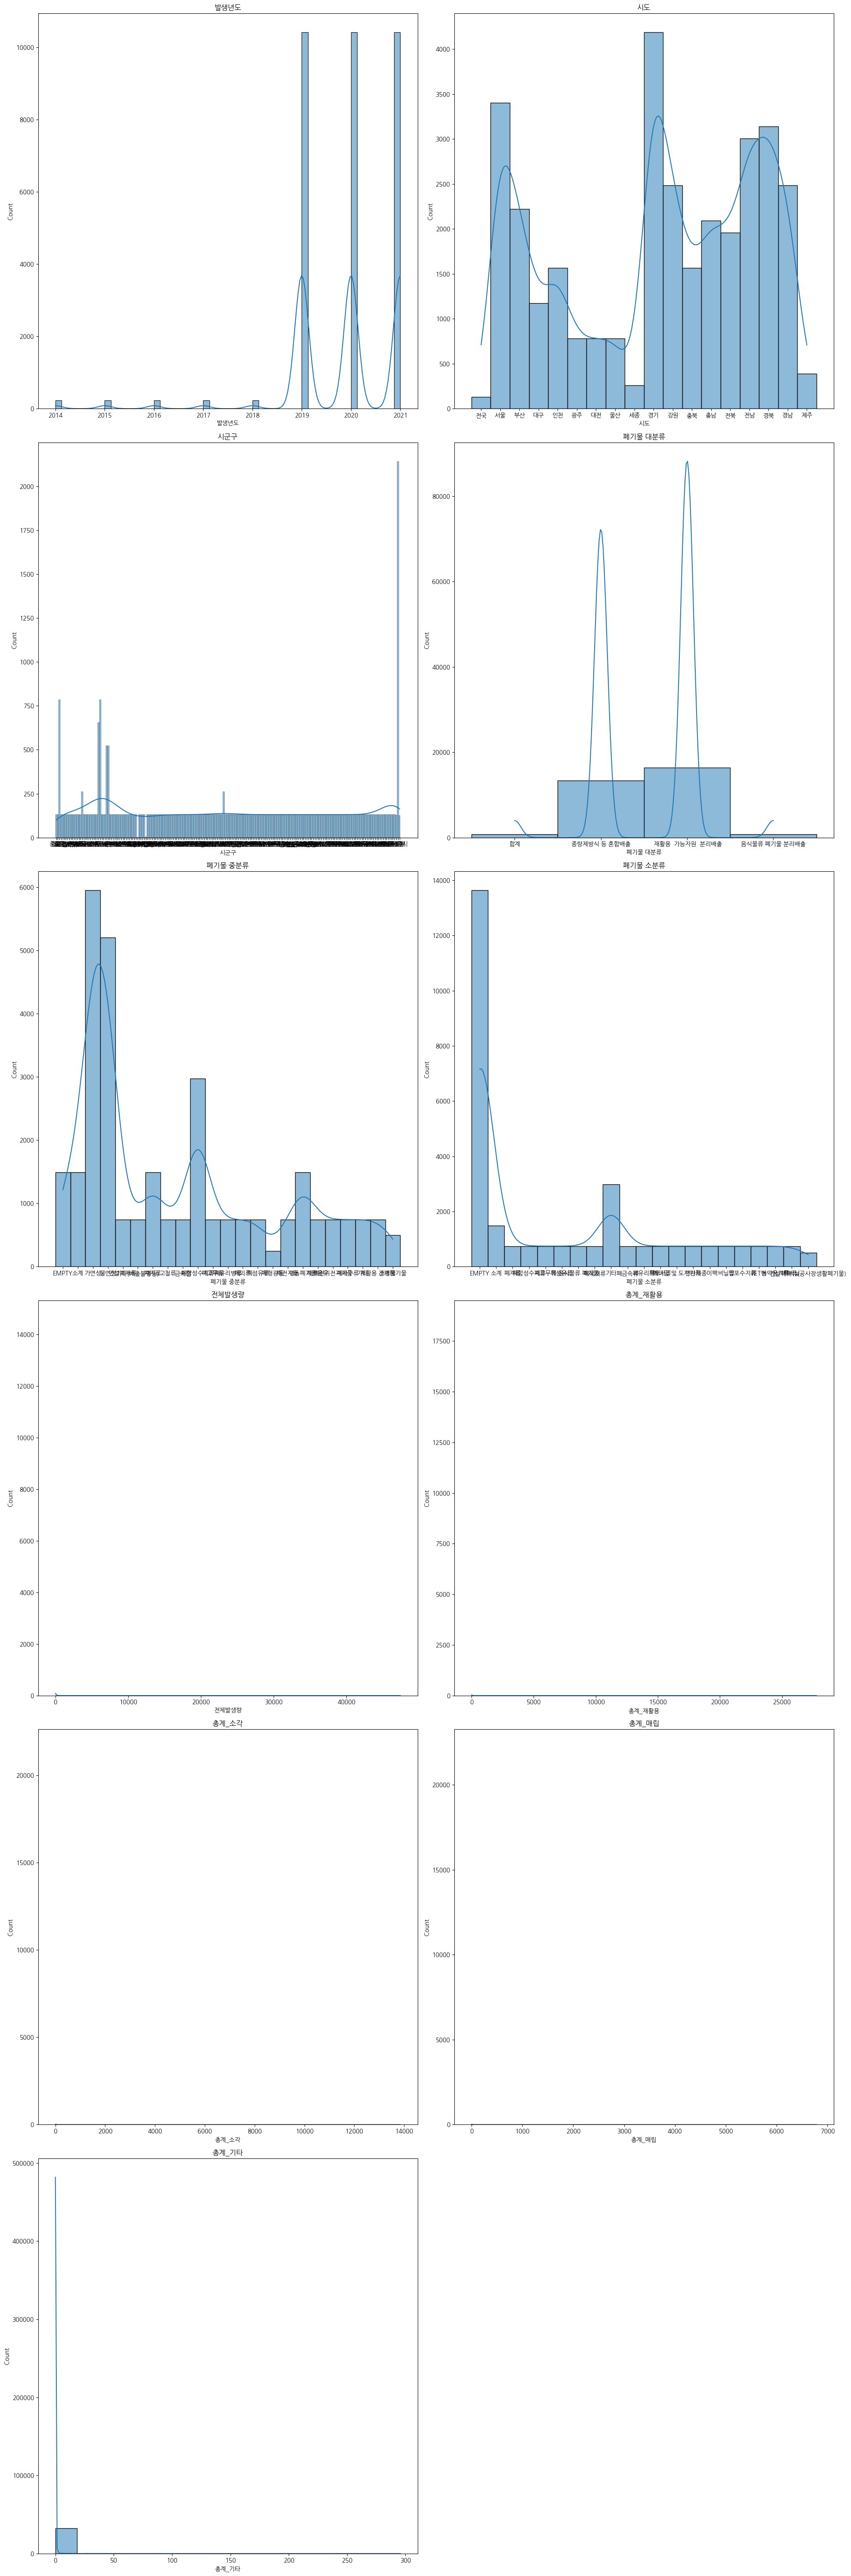

In [6]:
# 데이터의 분포 확인
# num_cols = len(data.columns)
# num_rows = (num_cols + 1) // 2  # 2개의 컬럼을 한 행에 배치, 필요한 행의 수 계산
# fig, axes = plt.subplots(num_rows, 2, figsize=(20, 10 * num_rows))  # 각 행의 높이를 10로 설정

# for i, col in enumerate(data.columns):
#     ax = axes[i // 2, i % 2]  # 행 인덱스는 i를 2로 나눈 몫, 열 인덱스는 i를 2로 나눈 나머지
#     sns.histplot(data[col], kde=True, ax=ax)
#     ax.set_title(col)

# # 남은 subplot 공간이 있을 경우 비활성화
# for j in range(i + 1, num_rows * 2):
#     axes[j // 2, j % 2].axis('off')

# plt.tight_layout()
# plt.show()

### 데이터를 분석하고 예측 모델을 만들기 위해 다음과 같은 단계로 진행 합니다:

#### 1. 데이터 이해 및 전처리:

- 데이터의 컬럼을 분석하고, 결측값을 처리합니다.
- 명목형, 범주형 변수와 수치형 변수를 식별합니다.
- 데이터의 분포를 시각화하고, 이상치를 탐지합니다.

#### 2. 특성 엔지니어링:

- 필요에 따라 새로운 변수를 생성하거나 기존 변수를 변환합니다.
- 카테고리형 변수를 원-핫 인코딩(one-hot encoding) 또는 라벨 인코딩(label encoding)으로 변환합니다.
- 수치형 변수를 표준화 또는 정규화합니다.

#### 3. 모델 구축 및 평가:

- 데이터를 학습용(train)과 테스트용(test)으로 분할합니다.
- 적절한 회귀(regression) 또는 분류(classification) 모델을 선택합니다.
- 모델을 학습시키고 평가합니다.

먼저, 데이터의 기본 통계를 살펴보고 결측값을 처리한 다음, 시각화를 통해 데이터의 분포를 이해해 보겠습니다.

#### 1. 데이터 이해 및 전처리

In [7]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()

# Display the columns with missing values
missing_values[missing_values > 0]


폐기물 대분류    1155
폐기물 중분류    1155
폐기물 소분류    1155
dtype: int64

"폐기물 대분류", "폐기물 중분류", "폐기물 소분류" 컬럼에 결측값이 존재, 이 결측값들은 모든 행에서 동일하게 발생하고 있어 

우선, 이 결측값들을 처리하는 방법을 고려해야 하는데, 결측값이 있는 행들을 제거하거나 다른 방법으로 채울 수 있고,

여기서는 결측값이 있는 행들이 많으므로 폐기물 종류 컬럼을 제거하고 분석을 진행.

In [8]:
# '폐기물 대분류', '폐기물 중분류', '폐기물 소분류' columns 제거
data_cleaned = data.drop(columns=['폐기물 대분류', '폐기물 중분류', '폐기물 소분류'])

# 제거된 데이터의 구조 확인
data_cleaned.shape


(32403, 8)

여기서, 특성이 다른 2019년 이후 데이터 제거하고, 2019년 이전 데이터에서도 특성이 다른 데이터를 제거하고, 남은 데이터를 분석해 보겠습니다.
시도 데이터 중에서 '전국'을 제거하고, 남은 데이터를 분석해 보겠습니다.



In [9]:
# '발생년도' 2014년에서 2018년 데이터만 남기기
data_cleaned = data_cleaned[(data_cleaned['발생년도'] >= 2014) & (data_cleaned['발생년도'] <= 2018)]

# '시도' 컬럼에서 '전국' 데이터 행 제거
data_cleaned = data_cleaned[data_cleaned['시도'] != '전국']

# Check the shape of the cleaned data
data_cleaned.shape

(1150, 8)

In [10]:
# 데이터 앞에서 제거한 데이터를 조회
data_cleaned.head()

,발생년도,시도,시군구,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
1,2014,서울,종로구,290.9,170.4,88.1,32.4,0.0
2,2014,서울,중구,410.6,258.6,132.6,19.4,0.0
3,2014,서울,용산구,245.4,158.1,79.1,8.2,0.0
4,2014,서울,성동구,228.6,142.6,65.1,20.9,0.0
5,2014,서울,광진구,298.7,209.5,55.1,34.1,0.0


In [11]:
# 데이터 뒤에서 제거한 데이터를 조회
data_cleaned.tail()

,발생년도,시도,시군구,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
1150,2018,경남,함양군,43.2,7.4,15.6,20.2,0.0
1151,2018,경남,거창군,70.3,36.6,25.1,8.6,0.0
1152,2018,경남,합천군,37.6,16.2,9.4,12.0,0.0
1153,2018,제주,제주시,686.0,472.2,169.2,44.6,0.0
1154,2018,제주,서귀포시,278.2,209.8,50.1,18.3,0.0


#### 2. 데이터의 기본 통계 및 시각화

In [12]:
# Display basic statistics for numerical columns
data_cleaned.describe()


,발생년도,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
count,1150.000000,1150.000000,1150.000000,1150.000000,1150.000000,1150.0
mean,2016.000000,193.899913,113.982348,52.556957,27.360609,0.0
std,1.414829,187.913306,119.863900,65.709122,35.256243,0.0
min,2014.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,2015.000000,50.000000,20.500000,10.725000,5.100000,0.0
50%,2016.000000,137.650000,70.750000,31.500000,14.500000,0.0
75%,2017.000000,284.200000,175.250000,75.975000,33.750000,0.0
max,2018.000000,1131.100000,708.800000,458.700000,244.900000,0.0


이제 각 변수의 분포를 시각화해 보겠습니다. 히스토그램과 상자 그림(Box Plot)을 사용하여 데이터의 분포를 시각적으로 분석하겠습니다. ​

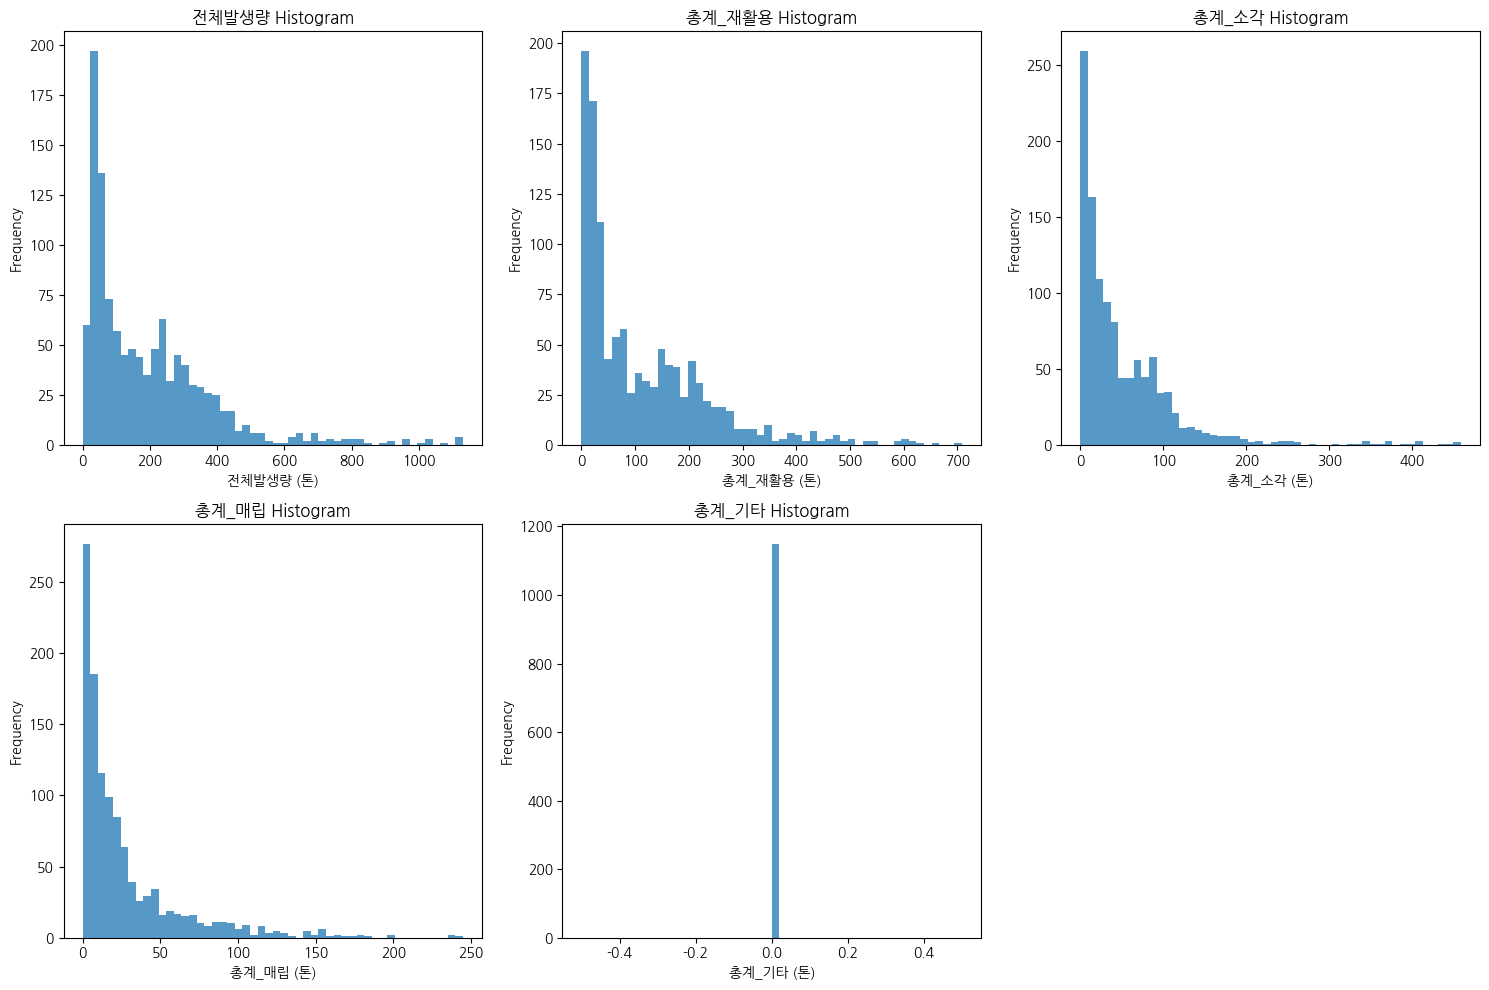

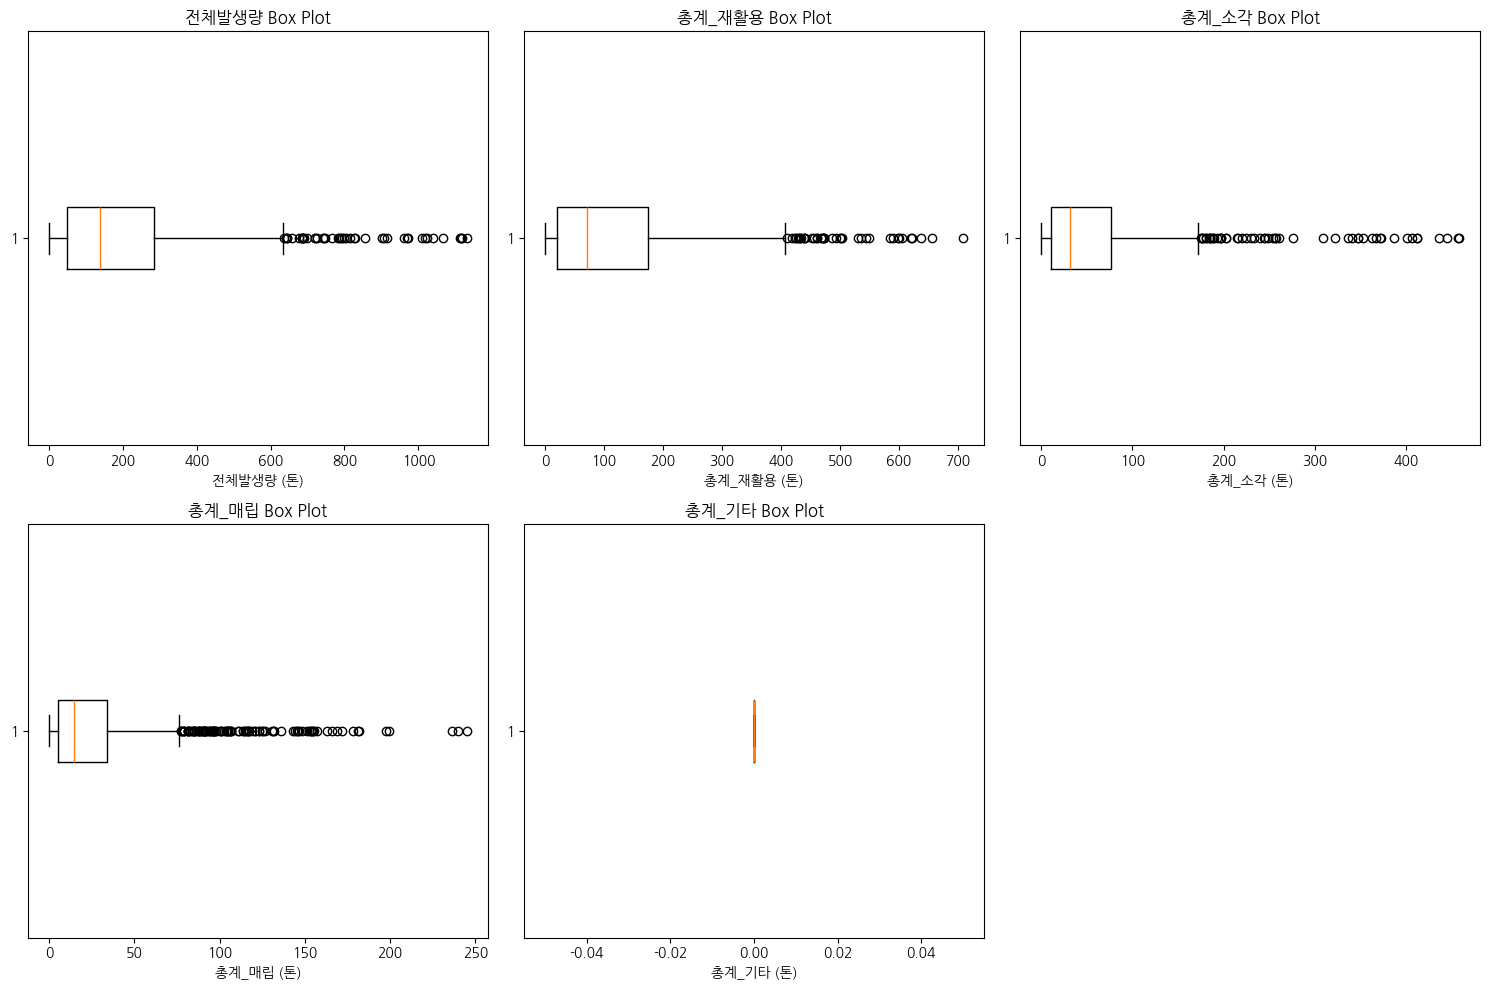

In [13]:
# Define numerical columns
numerical_cols = ['전체발생량', '총계_재활용', '총계_소각', '총계_매립', '총계_기타']

# Plot histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(data_cleaned[col], bins=50, alpha=0.75)
    plt.title(f'{col} Histogram')
    plt.xlabel(f'{col} (톤)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot box plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    plt.boxplot(data_cleaned[col], vert=False)
    plt.title(f'{col} Box Plot')
    plt.xlabel(f'{col} (톤)')
plt.tight_layout()
plt.show()


발생년도를 2009년에서 2013년까지 신규로 생성하면서, 시도 및 시군구 데이터는 2014년 데이터를 기준으로 사용하고, 나머지 수치형 데이터는 랜덤으로 생성하여 데이터 증폭을 수행

1. 2014년 데이터 필터링: 2014년 데이터를 기준으로 시도 및 시군구 정보를 추출합니다.
2. 발생년도 생성: 2009년에서 2013년 사이의 년도를 무작위로 선택합니다.
3. 시도 및 시군구 데이터 샘플링: 2014년 데이터에서 시도 및 시군구를 샘플링하여 새 데이터의 위치 정보로 사용합니다.
4. 수치형 데이터 생성: 전체발생량은 0에서 1000 톤 사이의 값을 무작위로 생성하고, 나머지 수치형 데이터는 전체발생량을 기준으로 적절히 분배하여 생성합니다.
5. 데이터프레임 생성 및 병합: 새로운 데이터프레임을 생성하고, 이를 원본 데이터에 추가합니다.

데이터의 다양성을 유지하면서 새로운 데이터를 생성하여 모델의 일반화 능력을 향상

In [14]:
import pandas as pd
import numpy as np

# 2014년 데이터 필터링
data_2014 = data_cleaned[data_cleaned['발생년도'] == 2014]
# 목표 데이터 수
target_data_count = 30000

# 발생년도를 2009년에서 2013년까지 신규로 생성
years = np.random.choice(range(2009, 2014), size=target_data_count, replace=True)

# 시도 및 시군구 데이터는 2014년 데이터를 기준으로 사용
cities = data_2014['시도'].sample(n=target_data_count, replace=True, random_state=42).values
districts = data_2014['시군구'].sample(n=target_data_count, replace=True, random_state=42).values

# 전체발생량을 data_cleaned의 전체발생량 분포를 따르도록 랜덤 생성
total_generation = np.random.choice(data_cleaned['전체발생량'], size=target_data_count, replace=True)
total_recycling = np.random.choice(data_cleaned['총계_재활용'], size=target_data_count, replace=True)  # 재활용량은 발생량 이하
total_incineration = np.random.choice(data_cleaned['총계_소각'], size=target_data_count, replace=True)
total_landfill = np.random.choice(data_cleaned['총계_매립'], size=target_data_count, replace=True)
# total_others 계산 시 음수 값을 0으로 변환
total_others = total_generation - total_recycling - total_incineration - total_landfill
total_others = np.clip(total_others, a_min=0, a_max=None)

# 총계_재활용, 총계_소각, 총계_매립, 총계_기타 데이터는 전체발생량을 기준으로 적절히 분배하여 랜덤 생성
# total_recycling = np.random.uniform(0, total_generation)  # 재활용량은 발생량 이하
# total_incineration = np.random.uniform(0, total_generation - total_recycling)
# total_landfill = np.random.uniform(0, total_generation - total_recycling - total_incineration)
# total_others = total_generation - total_recycling - total_incineration - total_landfill


# 새로운 DataFrame 생성
augmented_data = pd.DataFrame({
    '발생년도': years,
    '시도': cities,
    '시군구': districts,
    '전체발생량': total_generation,
    '총계_재활용': total_recycling,
    '총계_소각': total_incineration,
    '총계_매립': total_landfill,
    '총계_기타': total_others
})

# 증폭된 데이터를 원본 데이터에 추가
data_cleaned_augmented = pd.concat([data_cleaned, augmented_data])

# 결과 확인
print(data_cleaned_augmented.shape)
data_cleaned_augmented.head()

(31150, 8)


,발생년도,시도,시군구,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
1,2014,서울,종로구,290.9,170.4,88.1,32.4,0.0
2,2014,서울,중구,410.6,258.6,132.6,19.4,0.0
3,2014,서울,용산구,245.4,158.1,79.1,8.2,0.0
4,2014,서울,성동구,228.6,142.6,65.1,20.9,0.0
5,2014,서울,광진구,298.7,209.5,55.1,34.1,0.0


In [15]:
data_cleaned_augmented.describe()

,발생년도,전체발생량,총계_재활용,총계_소각,총계_매립,총계_기타
count,31150.000000,31150.000000,31150.000000,31150.000000,31150.000000,31150.000000
mean,2011.195088,192.972459,113.578934,52.187435,27.142604,83.094761
std,1.699309,187.750797,119.628229,65.380268,35.121997,154.942121
min,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,50.000000,20.000000,10.800000,5.100000,0.000000
50%,2011.000000,136.600000,70.200000,31.300000,14.500000,0.000000
75%,2012.000000,282.900000,175.300000,75.000000,33.400000,114.600000
max,2018.000000,1131.100000,708.800000,458.700000,244.900000,1112.600000


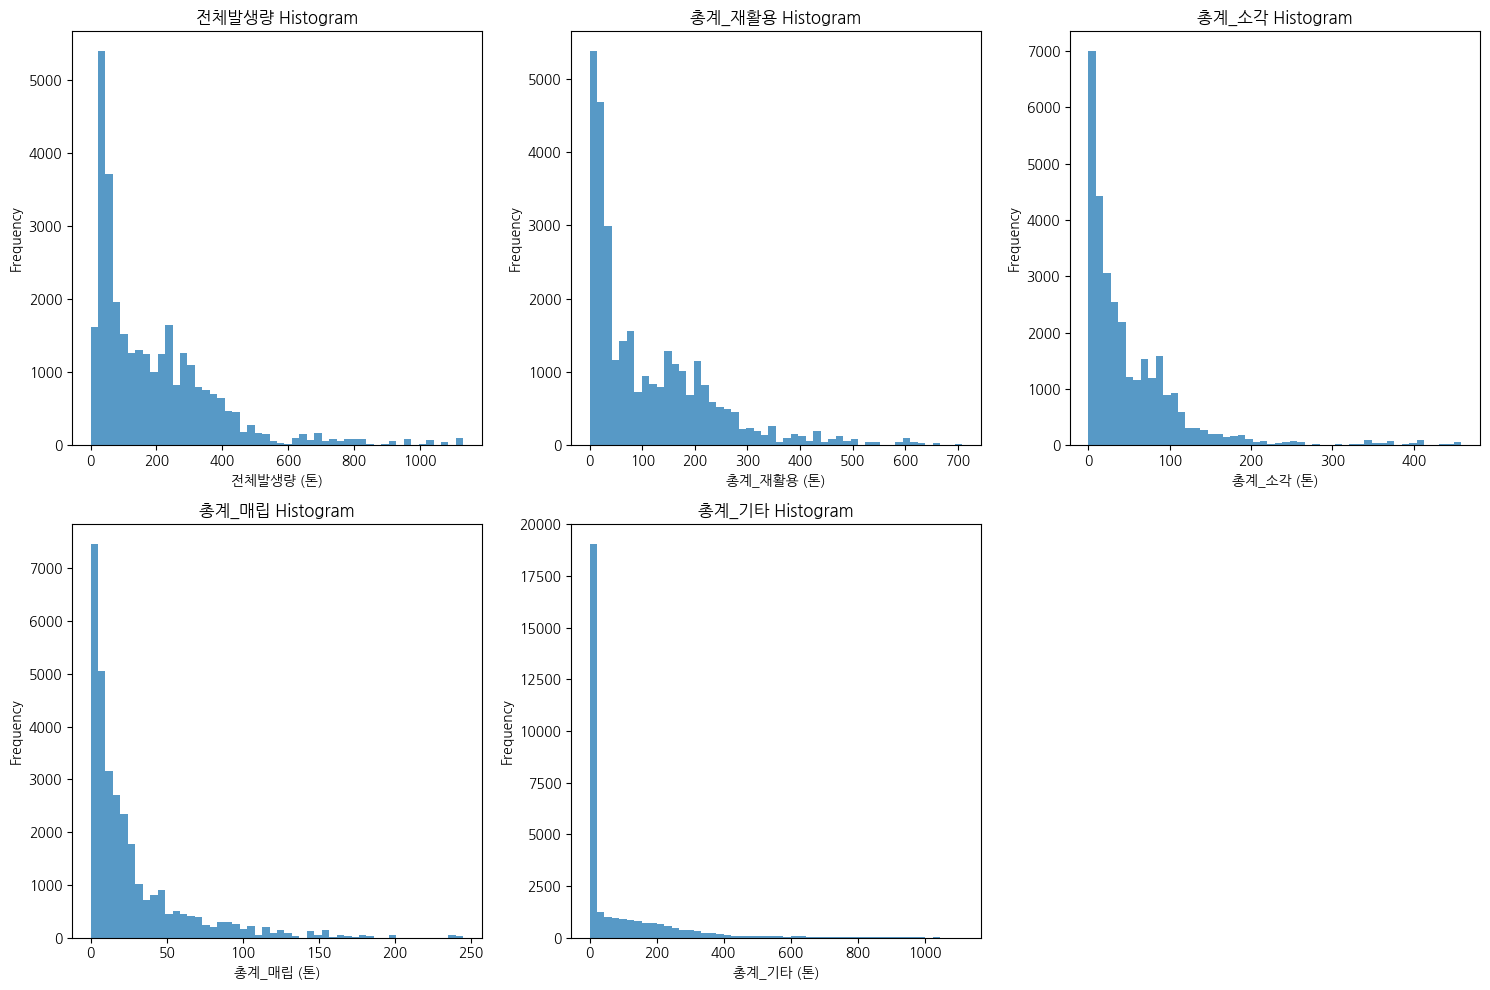

In [16]:
# Define numerical columns
numerical_cols = ['전체발생량', '총계_재활용', '총계_소각', '총계_매립', '총계_기타']

# Plot histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(data_cleaned_augmented[col], bins=50, alpha=0.75)
    plt.title(f'{col} Histogram')
    plt.xlabel(f'{col} (톤)')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [17]:
# 증폭된 데이터 저장
data_cleaned_augmented.to_csv('./data/data_cleaned_augmented.csv', index=False)

#### 1. 데이터 전처리
 - 범주형 변수 인코딩을 사용하여 변환합니다.
 - 수치형 변수는 표준화합니다.

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

# 데이터 불러오기
file_path = './data/data_cleaned_augmented.csv'
data = pd.read_csv(file_path)

# 범주형 변수 인코딩
le_sido = LabelEncoder()
le_sigungu = LabelEncoder()

data['시도'] = le_sido.fit_transform(data['시도'])
data['시군구'] = le_sigungu.fit_transform(data['시군구'])

# 특징 및 타겟 변수 정의
features = ['발생년도', '시도', '시군구']
targets = ['전체발생량', '총계_재활용', '총계_소각', '총계_매립']

X = data[features]
y = data[targets]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 2. 모델 학습 및 평가

회귀 모델

In [25]:
from sklearn.linear_model import LinearRegression

# 모델 학습 및 평가
regression_models = {}
for target in targets:
    model = LinearRegression()
    model.fit(X_train, y_train[target])
    regression_models[target] = model

# 평가
regression_evaluation = {}
for target in targets:
    y_pred = regression_models[target].predict(X_test)
    mae = mean_absolute_error(y_test[target], y_pred)
    regression_evaluation[target] = mae


In [26]:
regression_evaluation

{'전체발생량': 138.53189833123457,
 '총계_재활용': 95.07906296893948,
 '총계_소각': 44.630581921212546,
 '총계_매립': 24.30333075706541}

랜덤 포레스트

In [20]:
from sklearn.ensemble import RandomForestRegressor

# 모델 학습 및 평가
rf_models = {}
for target in targets:
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train[target])
    rf_models[target] = model

# 평가
rf_evaluation = {}
for target in targets:
    y_pred = rf_models[target].predict(X_test)
    mae = mean_absolute_error(y_test[target], y_pred)
    rf_evaluation[target] = mae


In [27]:
rf_evaluation

{'전체발생량': 138.7754136263818,
 '총계_재활용': 94.70619641167958,
 '총계_소각': 44.476313934888815,
 '총계_매립': 24.43495780392108}

엑스지부스트

In [28]:
import xgboost as xgb

# 모델 학습 및 평가
xgb_models = {}
for target in targets:
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train[target])
    xgb_models[target] = model

# 평가
xgb_evaluation = {}
for target in targets:
    y_pred = xgb_models[target].predict(X_test)
    mae = mean_absolute_error(y_test[target], y_pred)
    xgb_evaluation[target] = mae


In [29]:
xgb_evaluation

{'전체발생량': 137.51214882902696,
 '총계_재활용': 94.15174129561186,
 '총계_소각': 44.150544487479024,
 '총계_매립': 24.21428232023675}

In [31]:
xgb_evaluation['전체발생량']
### 3. 평가 결과 비교

137.51214882902696

### 3. 평가 결과 비교

In [22]:
import pandas as pd

# 결과 비교
evaluation_results = pd.DataFrame({
    'Linear Regression': regression_evaluation,
    'Random Forest': rf_evaluation,
    'XGBoost': xgb_evaluation,
}, index=['MAE'])

# 데이터프레임 출력
print("Model Evaluation Results:")
print(evaluation_results)

evaluation_results


Model Evaluation Results:
     Linear Regression  Random Forest  XGBoost
MAE                NaN            NaN      NaN


,Linear Regression,Random Forest,XGBoost
MAE,NaN,NaN,NaN


### 4. 예측 함수 생성

각 모델에 대한 예측 함수를 만듭니다.

In [23]:
def predict_waste(model_type, year, sido, sigungu):
    input_data = pd.DataFrame({
        '발생년도': [year],
        '시도': [le_sido.transform([sido])[0]],
        '시군구': [le_sigungu.transform([sigungu])[0]]
    })
    
    predictions = {}
    for target in targets:
        if model_type == 'linear':
            model = regression_models[target]
        elif model_type == 'random_forest':
            model = rf_models[target]
        elif model_type == 'xgboost':
            model = xgb_models[target]
        else:
            raise ValueError("Unsupported model type")
        
        predictions[target] = model.predict(input_data)[0]
    
    return predictions

# 예시 예측
example_prediction_linear = predict_waste('linear', 2024, '서울', '종로구')
example_prediction_rf = predict_waste('random_forest', 2024, '서울', '종로구')
example_prediction_xgb = predict_waste('xgboost', 2024, '서울', '종로구')

example_prediction_linear, example_prediction_rf, example_prediction_xgb


({'전체발생량': 204.13525064323426,
  '총계_재활용': 122.06256379285378,
  '총계_소각': 54.746861791086076,
  '총계_매립': 24.807131169343222},
 {'전체발생량': 335.6619999999996,
  '총계_재활용': 211.2739999999998,
  '총계_소각': 87.26200000000009,
  '총계_매립': 38.67199999999994},
 {'전체발생량': 356.62192,
  '총계_재활용': 203.36458,
  '총계_소각': 94.813705,
  '총계_매립': 45.355007})